# Stock market fluctuations

The fluctuations of stock prices represent an intriguing example of a complex random walk. Stock prices are influenced by transactions that are carried out over a broad range of time scales, from micro- to milliseconds for high-frequency hedge funds over several hours or days for day-traders to months or years for long-term investors. We therefore expect that the statistical properties of stock price fluctuations, like volatility and auto-correlation of returns, are not constant over time, but show significant fluctuations of their own. Time-varying parameter models can account for such changes in volatility and auto-correlation and update their parameter estimates in real-time.

There are, however, certain events that render previously gathered information about volatility or autocorrelation of returns completely useless. News announcements that are unexpected at least to some extent, for example, can induce increased trading activity, as market participants update their orders according to their interpretation of novel information. The resulting *"non-scheduled"* price corrections can often not be adequately described by the current estimates of volatility. Even a model that accounts for gradual variations in volatility cannot reproduce these large price corrections. Instead, when such an event happens, it becomes favorable to forget about previously gathered parameter estimates and completely start over. In this example, we use the *bayesloop* framework to specifically evaluate the probability of previously acquired information becoming useless. We interpret this probability value as a risk metric and evaluate it for each minute of an individual trading day (Nov 28, 2016) for the exchange-traded fund [SPY](https://www.google.com/finance?q=SPY). The announcement of macroeconomic indicators on this day results in a significant increase of our risk metric in intra-day trading.

In [8]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import numpy as np
# !pip install bayesloop
import bayesloop as bl
import sympy.stats as stats
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()  # use seaborn colors

# from async_tiingo import json_to_df
import aiohttp
import config
from urllib.parse import urlencode
from datetime import datetime, timedelta
import exchange_calendars as xcals
import time

In [20]:
# Get trading calendar for today
# !pip install exchange-calendars
one_minute = pd.Timedelta(1, "T")
nys = xcals.get_calendar("XNYS") # New York Stock Exchange
start_time = int(time.time() * 1000) - (500 - 2) * 60 * 1000
start = datetime.fromtimestamp(start_time / 1000).strftime('%Y-%m-%d')
nys.schedule.loc[start:]

,open,break_start,break_end,close
2022-12-27,2022-12-27 14:30:00+00:00,NaT,NaT,2022-12-27 21:00:00+00:00
2022-12-28,2022-12-28 14:30:00+00:00,NaT,NaT,2022-12-28 21:00:00+00:00
2022-12-29,2022-12-29 14:30:00+00:00,NaT,NaT,2022-12-29 21:00:00+00:00
2022-12-30,2022-12-30 14:30:00+00:00,NaT,NaT,2022-12-30 21:00:00+00:00
2023-01-03,2023-01-03 14:30:00+00:00,NaT,NaT,2023-01-03 21:00:00+00:00
...,...,...,...,...
2023-12-19,2023-12-19 14:30:00+00:00,NaT,NaT,2023-12-19 21:00:00+00:00
2023-12-20,2023-12-20 14:30:00+00:00,NaT,NaT,2023-12-20 21:00:00+00:00
2023-12-21,2023-12-21 14:30:00+00:00,NaT,NaT,2023-12-21 21:00:00+00:00
2023-12-22,2023-12-22 14:30:00+00:00,NaT,NaT,2023-12-22 21:00:00+00:00


In [2]:
async def json_to_df(json_response, symbol):
    try:
        df = pd.DataFrame(json_response)
        df.set_index('date', inplace=True)
        # df['date'] = pd.to_datetime(df['date'])
        df['symbol'] = symbol
        df = df[['symbol', 'open', 'high', 'low', 'close', 'volume']]
        return df
    except Exception as e:
        print(e)
        return pd.DataFrame()

In [3]:

"""
Get data from Tiingo API
Returns a numpy array of the 1min close prices for 1 day
"""
API_KEY = config.TIINGO_API_KEY
symbol = config.STOCK_SYMBOL
symbol = symbol.lower()
TIINGO_BATCH_API = "https://api.tiingo.com/iex/{}/prices?".format(symbol)
params = {
                'columns': 'date,open,high,low,close,volume',
                'startDate': '2022-12-22',  # (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d'),
                'endDate': '2022-12-22',  # (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d'),
                'resampleFreq': '1min',
                'token': API_KEY
            }
url = TIINGO_BATCH_API + urlencode(params)
async with aiohttp.ClientSession() as session:
    async with session.get(url) as response:
        json_response = await response.json()
        df = await json_to_df(json_response, symbol)
df = df.filter(['close'])
df.close = df.close.astype(float)
df = df.close[1:].values

In [4]:
import time

start = int(time.time()*1000) - (500-2)*60*1000
# convert to datetime format YYYY-MM-DD
start = datetime.fromtimestamp(start/1000).strftime('%Y-%m-%d')  #  HH:%M:%S')
start

'2022-12-25'

In [5]:
# print(url)

In [6]:
# count values in data
data = df.copy()
print('Number of values in data: {}'.format(len(data)))
print(data)

Number of values in data: 390
[133.75  133.54  133.44  133.29  133.435 133.62  133.73  133.71  133.49
 133.27  133.53  133.7   133.665 133.71  133.34  133.54  133.67  133.48
 133.435 133.51  133.58  133.41  133.505 133.3   133.335 133.53  133.475
 133.47  133.53  133.275 132.915 132.92  132.92  132.865 132.675 132.72
 132.695 132.7   132.725 132.59  132.4   132.315 132.365 132.455 132.39
 132.4   132.44  132.4   132.48  132.425 132.28  132.2   132.195 132.07
 132.235 132.07  132.19  131.95  131.91  131.66  131.72  131.51  131.585
 131.34  131.36  131.345 131.44  131.19  131.26  131.22  131.5   131.61
 131.57  131.435 131.43  131.555 131.69  131.885 131.86  131.735 131.835
 131.88  131.885 131.8   131.645 131.73  131.57  131.58  131.54  131.55
 131.73  131.65  131.64  131.805 131.98  131.925 131.875 131.805 131.745
 131.795 131.62  131.67  131.675 131.71  131.69  131.865 131.78  131.75
 131.685 131.78  131.76  131.795 131.925 131.77  131.83  131.61  131.67
 131.64  131.625 131.62  131.6

In [7]:
# print the last 1 value
print('Last value in data: {}'.format(data[-1]))

Last value in data: 132.37


In [8]:
# function to slice 7 points in a range len(index.data) sorted by index where the last point is len(index.data) and the first point is the first point
def get_points(index, n=8):
    points = []
    for i in range(n):
        points.append(int(len(index.data) * i / (n - 1)))
    return points
print(get_points(data)[1:])

[55, 111, 167, 222, 278, 334, 390]


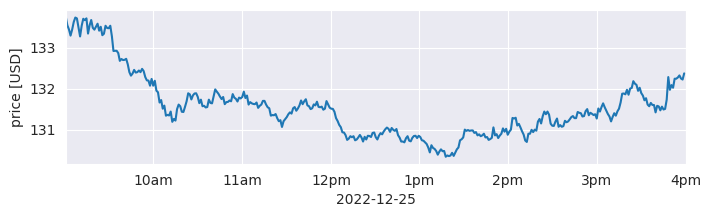

In [9]:
prices = np.array(data)
plt.figure(figsize=(8,2))
plt.plot(prices)
plt.ylabel('price [USD]')
plt.xlabel(datetime.now().strftime('%Y-%m-%d'))
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlim([0, len(prices)]);

In [10]:
# function to calculate log standard deviation of returns (volatility) for prices using a rolling window x minutes wide
# def log_std(array, window: int):
#     returns = np.log(array[1:]) - np.log(array[:-1])
#     return np.log(np.std(returns[-window:]))

## for data in [prices]:
def log_std(returns):
    return np.log(returns).std()


## Persistent random walk model

In this example, we choose to model the price evolution of SPY as a simple, well-known random walk model: the auto-regressive process of first order. We assume that subsequent log-return values $r_t$ of SPY obey the following recursive instruction:

$$
r_t = \rho_t \cdot r_{t-1} + \sqrt{1-\rho^2} \cdot \sigma_t \cdot \epsilon_t
$$

with the time-varying correlation coefficient $\rho_t$ and the time-varying volatility parameter $\sigma_t$. Here, $\epsilon_t$ is drawn from a standard normal distribution and represents the driving noise of the process and the scaling factor $\sqrt{1-\rho_t^2}$ makes sure that $\sigma_t$ is the standard deviation of the process. In *bayesloop*, we define this observation model as follows:

```
bl.om.ScaledAR1('rho', bl.oint(-1, 1, 100), 'sigma', bl.oint(0, 0.006, 400))
```
This implementation of the correlated random walk model will be discussed in detail in the next section.

Looking at the log-returns of our example, we find that the magnitude of the fluctuations (i.e. the volatility) is higher after market open and before market close. While these variations happen quite gradually, a peak around 10:10am, 11:20 and another large one around 13:54pm, the latter representing an abrupt price correction.

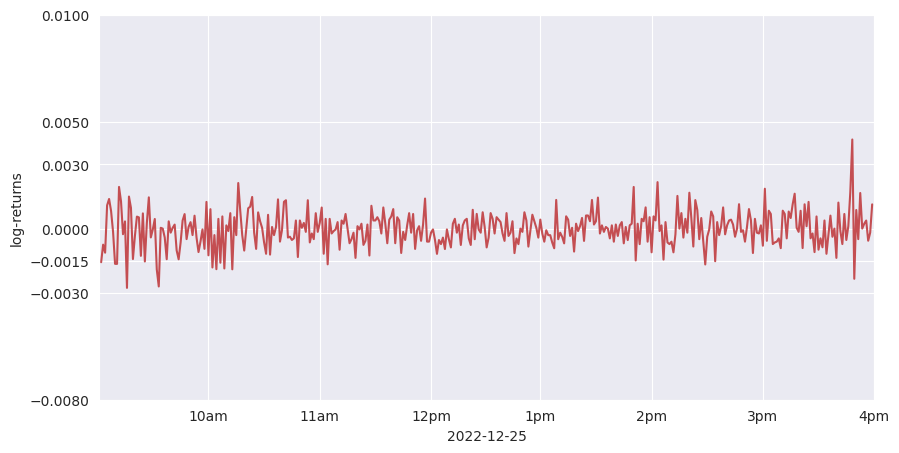

In [11]:
logPrices = np.log(data)
logReturns = np.diff(logPrices)

len_values: int = len(data)

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len_values), logReturns, c='r')
plt.ylabel('log-returns')
plt.xlabel(datetime.today().strftime('%Y-%m-%d'))
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.yticks([-0.008, -0.0030, -0.0015, 0, 0.005, 0.0030, 0.01])
plt.xlim([0, len_values]);

## Online study

*bayesloop* provides the class `OnlineStudy` to analyze on-going data streams and perform model selection for each new data point. In contrast to other Study types, more than just one transition model can be assigned to an `OnlineStudy` instance, using the method `addTransitionModel`. Here, we choose to add two distinct scenarios:

- **normal:** Both volatility and correlation of subsequent returns are allowed to vary gradually over time, to account for periods with above average trading activity after market open and before market close. This scenario therefore represents a smoothly running market.

- **chaotic:** This scenario assumes that we know nothing about the value of volatility or correlation. The probability that this scenario gets assigned in each minute therefore represents the probability that previously gathered knowledge about market dynamics cannot explain the last price movement.

By evaluating how likely the *chaotic* scenario explains each new minute close price of SPY compared to the *normal* scenario, we can identify specific events that lead to extreme fluctuations in intra-day trading.

First, we create a new instance of the `OnlineStudy` class and set the observation model introduced above. The keyword argument `storeHistory` is set to `True`, because we want to access the parameter estimates of all time steps afterwards, not only the estimates of the last time step.

In [12]:
# calculate log standard deviation of returns (volatility) 1 day
sigma = log_std(prices)
sigma

0.005795994381055646

In [13]:
S = bl.OnlineStudy(storeHistory=True)

L = bl.om.ScaledAR1('rho', bl.oint(-1, 1, 100), 
                    'sigma', bl.oint(0, sigma, 800))

S.set(L)

+ Created new study.
  --> Hyper-study
  --> Online study
+ Observation model: Scaled autoregressive process of first order (AR1). Parameter(s): ['rho', 'sigma']


### Adding transition models
**Note:** While the parameter `rho` is naturally constrained to the interval ]-1, 1[, the parameter boundaries of `sigma` have to be specified by the user. Typically, one can review past log-return data and estimate the upper boundary as a multiple of the standard deviation of past data points.

Both scenarios for the dynamic market behavior are implemented via the method `add`. The *normal* case consists of a combined transition model that allows both volatility and correlation to perform a Gaussian random walk. As the standard deviation (magnitude) of the parameter fluctuations is a-priori unknown, we supply a wide range of possible values (`bl.cint(0, 1.5e-01, 15)` for `rho`, which corresponds to 15 equally spaced values within the closed interval [0, 0.15], and 50 equally spaced values within the interval [0, 1.5$\cdot$10$^{-4}$] for `sigma`). 


Since we have no prior assumptions about the standard deviations of the Gaussian random walks, we let *bayesloop* assign equal probability to all values. If one wants to analyze more than just one trading day, the (hyper-)parameter distributions from the end of one day can be used as the prior distribution for the next day! One might also want to suppress large variations of `rho` or `sigma` with an exponential prior, e.g.:

```
bl.tm.GaussianRandomWalk('s1', bl.cint(0, 1.5e-01, 15), target='rho', 
                         prior=stats.Exponential('expon', 1./3.0e-02))
```

The *chaotic* case is implemented by the transition model `Independent`. This model sets a flat prior distribution for the parameters volatility and correlation in each time step. This way, previous knowledge about the parameters is not used when analyzing a new data point.

In [14]:
T1 = bl.tm.CombinedTransitionModel(
         bl.tm.GaussianRandomWalk('s1', bl.cint(0, 1.5e-01, 15), target='rho', prior=stats.Exponential('expon', 1./3.0e-02)),
         bl.tm.GaussianRandomWalk('s2', bl.cint(0, 1.5e-04, 50), target='sigma')
     )

T2 = bl.tm.Independent()

S.add('normal', T1)
S.add('chaotic', T2)

+ Added transition model: normal (750 combination(s) of the following hyper-parameters: ['s1', 's2'])
+ Added transition model: chaotic (no hyper-parameters)


Before any data points are passed to the study instance, we further provide prior probabilities for the two scenarios. We expect about one news announcement containing unexpected information per day and set a prior probability of $1/390$ for the *chaotic* scenario (one normal trading day consists of 390 trading minutes).

In [15]:
# 2 trading days --> 1 news announcement per day
S.setTransitionModelPrior([(len_values-1)/len_values, 1/len_values])

+ Set custom transition model prior.


Finally, we can supply log-return values to the study instance, data point by data point. We use the `step` method to infer new parameter estimates and the updated probabilities of the two scenarios. Note that in this example, we use a `for` loop to feed all data points to the algorithm because all data points are already available. In a real application of the `OnlineStudy` class, one can supply each new data point as it becomes available and analyze it in real-time.

In [17]:
for r in tqdm_notebook(logReturns):
    S.step(r)

/tmp/ipykernel_27636/218998061.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for r in tqdm_notebook(logReturns):


  0%|          | 0/389 [00:00<?, ?it/s]

+ Start model fit
+ Not enough data points to start analysis. Will wait for more data.
    + Set uniform prior with parameter boundaries.


In [19]:
# S.eval('r', logReturns[-1])

## Volatility spikes

Before we analyze how the probability values of our two market scenarios change over time, we check whether the inferred temporal evolution of the time-varying parameters is realistic. Below, the log-returns are displayed together with the inferred marginal distribution (shaded red) and mean value (black line) of the volatility parameter, using the method `plotParameterEvolution`.

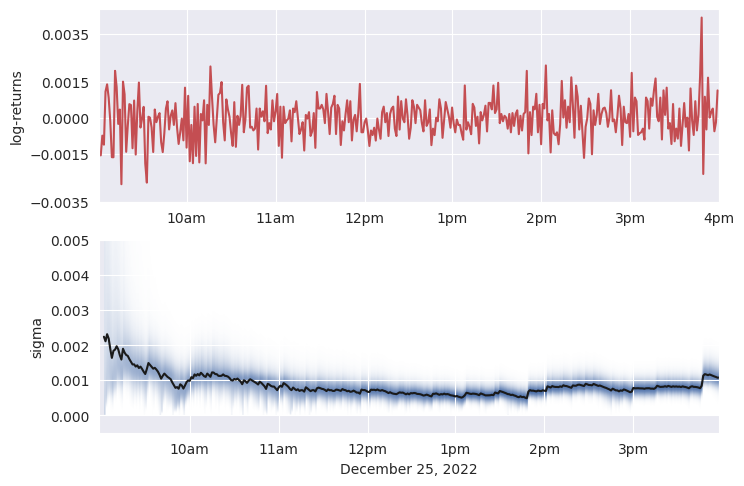

In [20]:
plt.figure(figsize=(8, 5.5))

# data plot
plt.subplot(211)
plt.plot(np.arange(1, len_values), logReturns, c='r')

plt.ylabel('log-returns')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.yticks([-0.0015, -0.0035, 0, 0.0035, 0.0015])
plt.xlim([0, len_values])

# parameter plot
plt.subplot(212)
S.plot('sigma', color='b')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlabel(datetime.today().strftime('%B %d, %Y'))
plt.ylim([-0.0005, 0.0050])
plt.xlim([-2, len_values-2]);

Note that the volatility estimates of the first few trading minutes are not as accurate as later ones, as we initialize the algorithm with a non-informative prior distribution. One could of course provide a custom prior distribution as a more realistic starting point. Despite this *fade-in* period, the period of increased volatility after market open is captured nicely, as well as the (more subtle) increase in volatility during the last 45 minutes of the trading day. Large individual log-return values also result in an *volatility spikes* (around 10:30am and more subtle around 12:30pm).

## Islands of stability

The persistent random walk model does not only provide information about the magnitude of price fluctuations, but further quantifies whether subsequent log-return values are correlated. A positive correlation coefficient indicates diverging price movements, as a price increase is more likely followed by another increase, compared to a decrease. In contrast, a negative correlation coefficient indicates *islands of stability*, i.e. trading periods during which prices do not diffuse randomly (as with a corr. coeff. of zero). Below, we plot the price evolution of SPY on November 28, together with the inferred marginal distribution (shaded blue) and the corresponding mean value (black line) of the time-varying correlation coefficient.

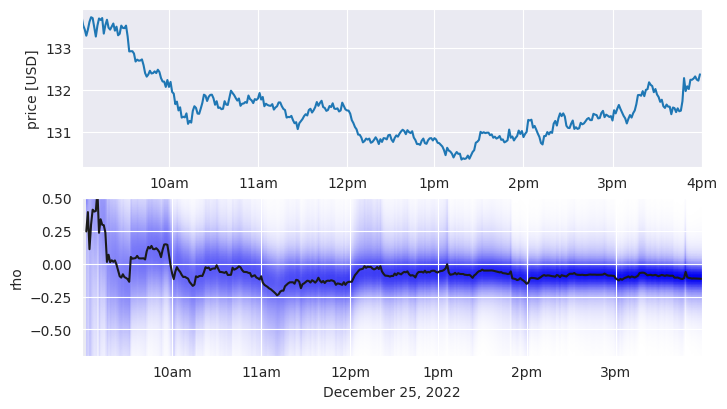

In [21]:
plt.figure(figsize=(8, 4.5))

# data plot
plt.subplot(211)
plt.plot(prices)

plt.ylabel('price [USD]')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlim([0, len_values])

# parameter plot
plt.subplot(212)
S.plot('rho', color='#0000FF')

plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlabel(datetime.today().strftime('%B %d, %Y'))
plt.ylim([-0.7, 0.5])
plt.xlim([-2, len_values-2]);

As a correlation coefficient that deviates significantly from zero would be immediately exploitable to predict future price movements, we mostly find correlation values near zero (in accordance with the efficient market hypothesis). However, between 1:15pm and 2:15pm, we find a short period of negative correlation with a value around -0.2. During this period, subsequent price movements tend to cancel each other out, resulting in an unusually strong price stability.

Using the `Parser` sub-module of *bayesloop*, we can evaluate the probability that subsequent return values are negatively correlated. In the figure below, we tag all time steps with a probability for `rho < 0` of 80% or higher and find that this indicator nicely identifies the period of increased market stability!


**Note:** The arbitrary threshold of 80% for our market indicator is of course chosen with hindsight in this example. In a real application, more than one trading day of data needs to be analyzed to create robust indicators!

In [22]:
# extract parameter grid values (rho) and corresponding prob. values (p)
rho, p = S.getParameterDistributions('rho')

# evaluate Prob.(rho < 0) for all time steps
P = bl.Parser(S)
p_neg_rho = np.array([P('rho < 0.', t=t, silent=True) for t in range(1, len_values-1)])

/tmp/ipykernel_27636/1832393766.py:24: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([mean, mean]);


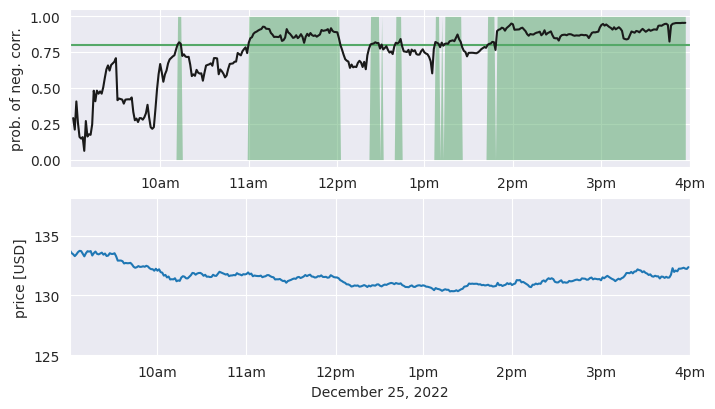

In [23]:
# plotting
# calculate median/mean of data
median = np.median(data)
mean = np.mean(data)

plt.figure(figsize=(8, 4.5))
plt.subplot(211)
plt.axhline(y=0.8, lw=1.5, c='g')
plt.plot(p_neg_rho, lw=1.5, c='k')
plt.fill_between(np.arange(len(p_neg_rho)), 0, p_neg_rho > 0.8, lw=0, facecolor='g', alpha=0.5)

plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.ylabel('prob. of neg. corr.')
plt.xlim([-2, len_values])

plt.subplot(212)
plt.plot(prices)
plt.fill_between(np.arange(2, len(p_neg_rho)+2), 8.24, 8.24 + (p_neg_rho > 0.8)*1.2, lw=0, facecolor='g', alpha=0.5)
plt.ylabel('price [USD]')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlim([0, len_values])
plt.ylim([mean, mean]);
plt.xlabel(datetime.today().strftime('%B %d, %Y'));

## Automatic tuning

One major advantage of the `OnlineStudy` class is that it not only infers the time-varying parameters of the *low-level* correlated random walk (the observation model `ScaledAR1`), but further infers the magnitude (the standard deviation of the transition model `GaussianRandomWalk`) of the parameter fluctuations and thereby tunes the parameter dynamics as new data arrives. As we can see below (left sub-figures), both magnitudes - one for `rho` and one for `sigma` - start off at a high level. This is due to our choice of a uniform prior, assigning equal probability to all hyper-parameter values before seeing any data. Over time, the algorithm *learns* that the true parameter fluctuations are less severe than previously assumed and adjusts the hyper-parameters accordingly. This newly gained information, summarized in the hyper-parameter distributions of the last time step (right sub-figures), could then represent the prior distribution for the next trading day.

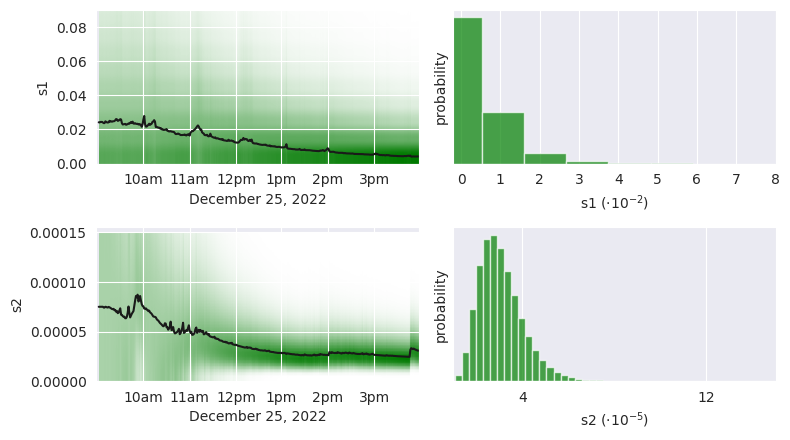

In [24]:
plt.figure(figsize=(8, 4.5))
plt.subplot(221)
S.plot('s1', color='green')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlabel(datetime.today().strftime('%B %d, %Y'))
plt.xlim([-2, len_values-2])
plt.ylim([0, 0.09])

plt.subplot(222)
S.plot('s1', t=len_values-2, facecolor='green', alpha=0.7)
plt.yticks([])
plt.xticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], ['0', '1', '2', '3', '4', '5', '6', '7', '8'])
plt.xlabel('s1 ($\cdot 10^{-2}$)')
plt.xlim([-0.002, 0.08])

plt.subplot(223)
S.plot('s2', color='green')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlabel(datetime.today().strftime('%B %d, %Y'))
plt.xlim([-2, len_values-2])
plt.ylim([0, 0.000155])

plt.subplot(224)
S.plot('s2', t=len_values-2, facecolor='green', alpha=0.7)
plt.yticks([])
plt.xticks([0.00004, 0.0008, 0.00012, 0.00016, 0.00020], ['4', '8', '12', '16', '20'])
plt.xlabel('s2 ($\cdot 10^{-5}$)')
plt.xlim([0.00001, 0.00015])

plt.tight_layout()

## Real-time model selection

Finally, we investigate which of our two market scenarios - *normal* vs. *chaotic* - can explain the price movements best. Using the method `plot('chaotic')`, we obtain the probability values for the *chaotic* scenario compared to the *normal* scenario, **with respect to all past data points**: 

Text(0, 0.5, 'p("chaotic")')

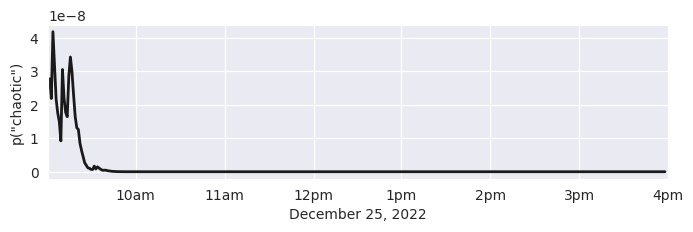

In [25]:
plt.figure(figsize=(8, 2))
S.plot('chaotic', lw=2, c='k')
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlabel(datetime.today().strftime('%B %d, %Y'))
plt.xlim([0, len_values])
plt.ylabel('p("chaotic")')

As expected, the probability that the *chaotic* scenario can explain all past log-return values at a given point in time quickly falls off to practically zero. Indeed, a correlated random walk with slowly changing volatility and correlation of subsequent returns is better suited to describe the price fluctuations of SPY **in the majority of time steps**.

However, we may also ask for the probability that each **individual** log-return value is produced by either of the two market scenarios by using the keyword argument `local=True`:

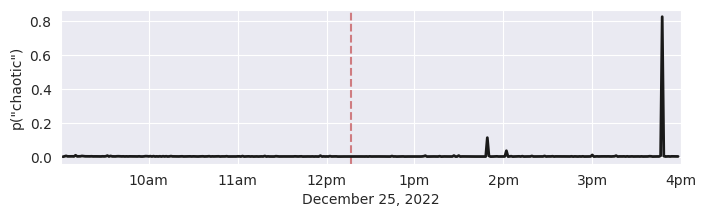

In [26]:
plt.figure(figsize=(8, 2))
S.plot('chaotic', local=True, c='k', lw=2)
plt.xticks((get_points(data)[1:]),
           ['10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm'])
plt.xlabel(datetime.today().strftime('%B %d, %Y'))
plt.xlim([0, len_values])
plt.ylabel('p("chaotic")')
plt.axvline(182, 0, 1, zorder=1, c='r', lw=1.5, ls='dashed', alpha=0.7)
plt.axvline(841, 0, 1, zorder=1, c='r', lw=1.5, ls='dashed', alpha=0.7);

Here, we find clear peaks indicating an increased probability for the *chaotic* scenario, i.e. that previously gained information about the market dynamics has become useless. Lets assume that we are concerned about market behavior as soon as there is at least a 1% risk that *normal* market dynamics can not describe the current price movement. This leaves us with three distinct events in the following time steps:

In [28]:
p = S.getTransitionModelProbabilities('chaotic', local=True)
np.argwhere(p > 0.05)

array([[267],
       [377]])

In [29]:
p = S.getTransitionModelProbabilities('chaotic', local=True)
np.argwhere(p > 0.1)

array([[267],
       [377]])

These time steps translate to the following trading minutes: **10:31am, 12:33pm and 3:54pm**.

The first peak at 10:31am directly follows the release of the [Texas Manufacturing Outlook Survey](http://www.dallasfed.org/news/releases/2016/nr161128.cfm) of the [Dallas Fed](http://www.dallasfed.org/). The publication of this set of economic indicators has already been announced by [financial news pages](http://finance.yahoo.com/news/10-things-know-opening-bell-113600334.html) before the market opened. While the title of the survey (*"Texas Manufacturing Activity Continues to Expand"*) indicated good news, investors reacted sceptically, possibly due to negative readings in both the *new orders index* and *growth rate of orders index* (c.f. [this article](http://247wallst.com/economy/2016/11/29/better-news-for-manufacturing-activity-in-texas/)).


**Note:** This first peak would be more pronounced if we had supplied a prior distribution that constrains strong parameter fluctuations!


The underlying trigger for the second peak, shortly after 12:30pm, remains unknown. No major macroeconomic indicators were published at that time, at least according to some economic news sites (see e.g. [nytimes.com](http://markets.on.nytimes.com/research/economy/indicators/indicators.asp?monthOffset=-3) or [liveindex.org](https://liveindex.org/46172/2016/11/us-pre-market-news-28-nov-2016/)).

The last peak at 3:54pm is likely connected to the imminent market close at 4pm. To protect themselves from unexpected news after trading hours, market participants often close their open positions before market close, generally leading to an increased volatility. If large market participants follow this behavior, price corrections may no longer be explained by *normal* market dynamics.

This example has shown that *bayesloop*'s `OnlineStudy` class can identify periods of increased volatility as well as periods of increased price stability (accompanied by a negative correlation of subsequent returns), and further automatically tunes its current assumptions about market dynamics. Finally, we have demonstrated that *bayesloop* serves as a viable tool to detect *"anomalous"* price corrections, triggered by large market participants or news announcements, in real-time.